# Goals and strategies

We give ourselves an image, which may have been altered by noise or by a linear transformation.

Let $X$ be the original image, without noise nor transformation.

Let $A$ be a linear transformation, for example, a convolution by a gaussian kernel, and let $\eta$ be a noise term, which will be an additive gaussian white noise over the whole image. Then the transformed image $Z$ has the form:

$$Z = AX + \eta$$

If $A$ is invertible, and if there is no noise ($\eta=0$), then
$Z = AX$, and $X$ satisfies:

$$X = \mathrm{argmin}_{U}(\frac{1}{2}\|AU - Z\|^2_2)$$

Suppose now that $\eta$ is nonzero. We would also like to remove $\eta$ to find $X$, insofar as it is possible. The assumption that the noise is a gaussian white noise, implies that the noise has high frequency, whereas the original image should be more smooth: transitions from one pixel to the next should be smooth almost everywhere (a pixel of blue sky is probably surrounder by other blue pixels).


This peculiarity of a random noise leads us to consider a kind of discrete derivative on the image's horizontal and vertical dimensions, on which we will apply our penalty. More specifically, the difference operator $D$ acts on the array of pixels $(p[x,y])_{x,y}$ by returning the following quantity at position $(x,y)$
$$(p[x+1,y]-p[x-1,y], p[x,y+1]-p[x,y-1])$$

Applying an L1 norm to this quantity, we obtain the following loss function:

$$\ell(U, Z) = \frac{1}{2}\|AU - Z\|_2^2 + \lambda \|DU\|_1$$

Finally, we can constrain the optimization to a convex set $C$. To obtain this constraint, we just have to add the indicator function $\iota_C$, which will give the loss an infinite value outside $C$ and won't change the minimization problem inside $C$. In this way,

$$\mathrm{argmin}_{U}(\frac{1}{2}\|AU - Z\|_2^2 + \lambda \|DU\|_1 + \iota_C) = \mathrm{argmin}_{U, U\in C}(\frac{1}{2}\|AU - Z\|_2^2 + \lambda \|DU\|_1)$$

The convex C we'll consider is:
$$ C = \{(x_i)_i | 0\leq x_i \leq 1\}$$since we chose the gray level of the image's pixels to be between 0 and 1.


## Approaches
In our course, only one algorithm is suitable for the function we are trying to minimize. This algorithm is the Condat-Vu algorithm, which does not require us to compute the prox of $$\frac{1}{2}\|A\cdot - Z\|_2^2$$

# Imports and opening images
Necessary dependencies

In [1]:
!git clone -b master https://github.com/SisyphusMountain/ImageRestoration.git

'git' n’est pas reconnu en tant que commande interne
ou externe, un programme exécutable ou un fichier de commandes.


In [2]:
%cd ImageRestoration

[WinError 2] Le fichier spécifié est introuvable: 'ImageRestoration'
C:\Users\cleme\projet_optim


In [3]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import torchvision as tv
from IPython.display import display, clear_output
from tqdm import tqdm
from time import perf_counter
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

True


## Opening the images
Some parameters in our algorithms give different results depending on the image size. Therefore, we cast all our images into a square format with the same resolution.

In [4]:
from PIL import Image

def crop_and_downsample(image_path, size=(512, 512)):
    """
    Crop a PIL Image to a square shape and downsample it to the specified size.

    Parameters:
    image (PIL.Image): The input image.
    size (tuple, optional): The target size after downsampling, default is (512, 512).

    Returns:
    PIL.Image: The processed image.
    """
    image = Image.open(image_path)
    width, height = image.size

    crop_size = min(width, height)

    left = (width - crop_size) / 2
    top = (height - crop_size) / 2
    right = (width + crop_size) / 2
    bottom = (height + crop_size) / 2

    image_cropped = image.crop((left, top, right, bottom))
    image_downsampled = image_cropped.resize(size, Image.LANCZOS)
    image_downsampled = image_downsampled.convert("L")
    return image_downsampled



## Transforming to tensors

In [5]:
def image_to_tensor(image):
    """The image is transformed into a tensor, where pixel values are encoded by
    a float between 0 and 1"""
    transform = transforms.Compose([
        transforms.ToTensor(),  # Convert the image to a tensor
    ])
    return transform(image)



# Adding noise


We'll consider the case where $A$ is a gaussian blur: it's a convolution with a gaussian kernel.

In [6]:
def gaussian_blur_and_noise(image, std_noise, gaussian_std=10, kernel_size=51, print_image=True,image_size=(512,512)):
    # Gaussian blur + noise
    # Show original
    printed_image = image.clone().detach()
    if print_image:
        print(f"original shape {printed_image.shape}")
    printed_image = transforms.ToPILImage()(printed_image).resize(image_size)
    if print_image:
        display(printed_image)
    noise = torch.randn(image.shape) * std_noise
    blurred_image = tv.transforms.functional.gaussian_blur(image, kernel_size=kernel_size, sigma=gaussian_std)
    noisy_image = blurred_image + noise
    noisy_image = torch.clamp(noisy_image, 0, 1)
    printed_image = noisy_image.clone().detach()
    if print_image:
        print(f"new shape {printed_image.shape}")
    printed_image = transforms.ToPILImage()(printed_image).resize(image_size)
    if print_image:
        display(printed_image)
    return noisy_image

The cell below shows an example of a blurred image and a noised image.

original image


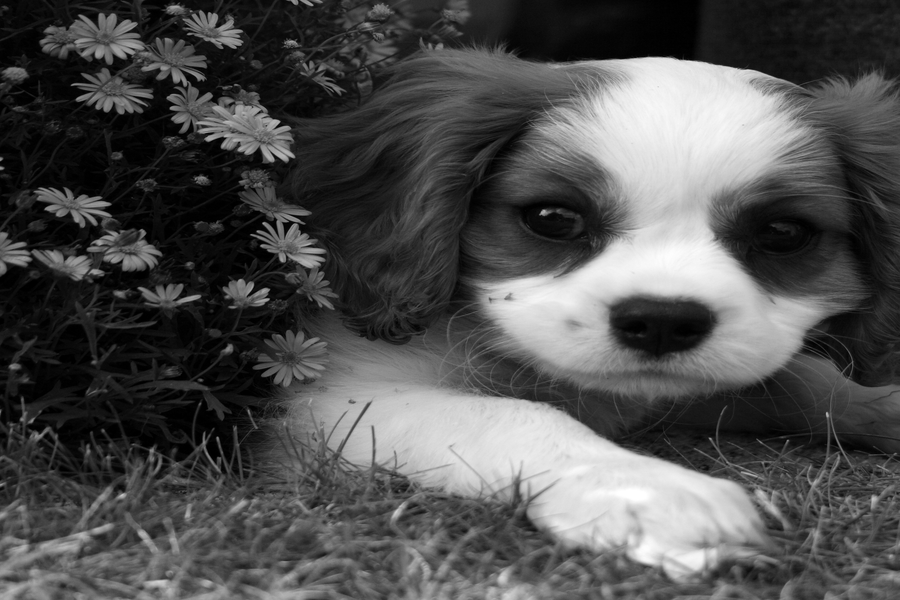

blurred image


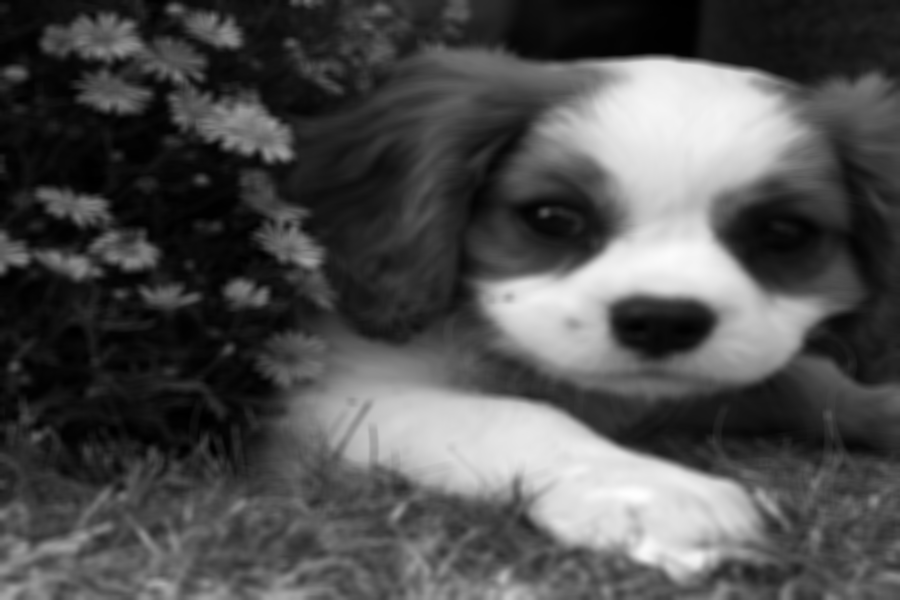

noised image


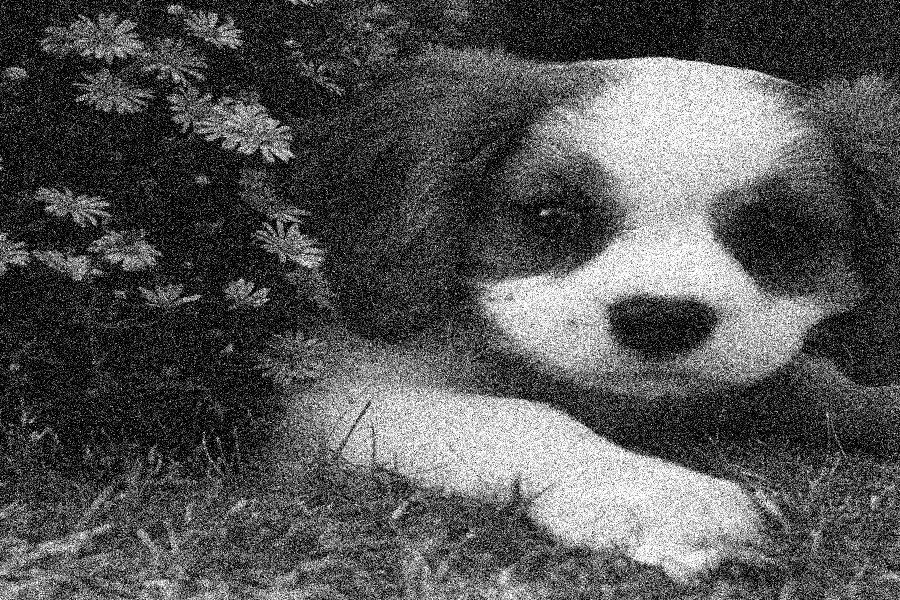

In [7]:
dog_image=crop_and_downsample("dog.jpg",size=(900,600))
dog_tensor=image_to_tensor(dog_image)
dog_blurred = gaussian_blur_and_noise(dog_tensor,std_noise=0,gaussian_std=150,kernel_size=9,print_image=False,image_size=(900,600))
dog_noised = gaussian_blur_and_noise(dog_tensor,std_noise=0.2,gaussian_std=0.1,kernel_size=5,print_image=False,image_size=(900,600))
dog_blurred_image = transforms.ToPILImage()(dog_blurred)
dog_noised_image = transforms.ToPILImage()(dog_noised)
print('original image')
display(dog_image)
print('blurred image')
display(dog_blurred_image)
print('noised image')
display(dog_noised_image)

# Difference operator
The difference operator is like a convolution by a particular kernel. We apply this difference operator along the vertical and horizontal dimensions.

In [8]:
#D et D^T

def GradientHor(x):
    y=x-torch.roll(x,1,dims=2)
    y[0,:,0]=0
    return y

def GradientVer(x):
    y=x-torch.roll(x,1,dims=1)
    y[0,0,:]=0
    return y

def DivHor(x):
    N=(x[0,0]).numel()
    y=x-torch.roll(x,-1,dims=2)
    y[0,:,0]=-x[0,:,1]
    y[0,:,N-1]=x[0,:,N-1]
    return y

def DivVer(x):
    N=len(x[0])
    y=x-torch.roll(x,-1,dims=1)
    y[0,0,:]=-x[0,1,:]
    y[0,N-1,:]=x[0,N-1,:]
    return y

def Psi(x):
    return torch.stack((GradientHor(x), GradientVer(x)))

def Psit(y):
    x=DivHor(y[0])+DivVer(y[1])
    return x


# Gaussian Blur Operator
The gaussian blur operator is a convolution by a gaussian kernel.

In [9]:
#operator A

def A_op(image_size,noise):
    s=noise
    n=image_size[0]
    m=image_size[1]
    x = torch.concatenate( (torch.arange(0,n/2), torch.arange(-n/2,0)) ).to(device);
    xbis = torch.concatenate( (torch.arange(0,m/2), torch.arange(-m/2,0)) ).to(device);
    [Y, X] = torch.meshgrid(x, xbis)
    h = torch.exp((-X**2-Y**2)/ (2*s**2)).to(device)
    h = h/sum(h.flatten())

    return lambda x: torch.real(torch.fft.ifft2(torch.fft.fft2(x) * torch.fft.fft2(h)))

#operator A^T

def At_op(image_size,noise):
    s=noise
    n=image_size[0]
    m=image_size[1]
    x = torch.concatenate( (torch.arange(0,n/2), torch.arange(-n/2,0)) ).to(device);
    xbis = torch.concatenate( (torch.arange(0,m/2), torch.arange(-m/2,0)) ).to(device);
    [Y, X] = torch.meshgrid(x, xbis)
    h = torch.exp((-X**2-Y**2)/ (2*s**2)).to(device)
    h = h/sum(h.flatten())

    return lambda x: torch.real(torch.fft.ifft2(torch.fft.fft2(x) * torch.conj(torch.fft.fft2(h))))


# Approaches

## Condat-Vu

Recall that we want to find the solution to the following optimization problem:
$$\mathrm{argmin}_{x}(\frac{1}{2}\|Ax - z\|_2^2 + \alpha \|Dx\|_1 + \iota_C(x))$$

where $A$ is the gaussian blur operator, $D$ is the finite difference operator (along vertical and horizontal directions), $\alpha$ is a non negative parameter, and
$$ C = \{(x_i)_i | 0\leq x_i \leq 1\}$$

We will apply the Condat-Vu algorithm:
\begin{equation}
\forall n \in \mathbb{N}, \begin{cases} p_n = prox_{\tau f}(x_n - \tau( \nabla h(x_n ) +L^* v_n ) ) \\
q_n =prox_{\gamma g^*}(v_n + \gamma (L(2p_n - x_n))) \\
(x_{n+1} , v_{n+1}) = (x_n , v_n) + \lambda_n((p_n,q_n) - (x_n, v_n))
\end{cases}
\end{equation}
with $f= i_c$,$h = \frac{1}{2} \| A \cdot -z \| _{2}^{2}$, $g=\alpha \| \cdot \|_{1}$ and $L = D$.

We compute:

\begin{equation}
prox_{\tau f} (x) =  P_{C}(x)
\end{equation}

\begin{equation}
prox_{\gamma g^{*}} (x) = P_{B_\infty(0, \alpha)}(x)
\end{equation}
\begin{equation}
\nabla{h}(x) = A^*(Ax-z)
\end{equation}
where $B_\infty$ is the infinite norm ball in $\mathbb{R}^{n^2}$.


Thus, the algorithm gives:
\begin{equation}
\forall n \in \mathbb{N}, \begin{cases} p_n =P_{C}(x_n - \tau( A^*(Ax-z) + D^* v_n ) ) \\
q_n =P_{B_\infty(0, \alpha)}(v_n + \gamma (D(2p_n - x_n))) \\
(x_{n+1} , v_{n+1}) = (x_n , v_n) + \lambda_n((p_n,q_n) - (x_n, v_n))
\end{cases}
\end{equation}

The blurring operator $A$ is a linear operator with operator norm $\leq 1$ (this operation is also known as Weierstrass transformation). The transpose $A^*$ of this operator also has norm $\leq 1$, so $\|A^* A\|\leq 1$, so the gradient of $h$ is $1$-lipschitz continuous.

Therefore, $h\in \mathcal{C}^{1,1}_{1}$.

To ensure convergence, we need the condition:

$\frac{1}{\tau} - \gamma \|L\|^2 > \frac{\zeta}{2}$


The two components of the finite difference operator (along vertical and horizontal directions) are sums of two translations. Therefore, these components have norm $\leq 2$.
Hence, the finite difference operator's norm is $\leq 4$.


We can therefore rewrite the condition as
$$\frac{1}{\tau} - \gamma \times 16 > \frac{1}{2}$$
because we have $\zeta = \|A^* A\|\leq 1$.

In [10]:
#prox_f and prox_g

def prox_f(x):
    return torch.clamp(x, 0, 1)

def prox_g(x, alpha):
    return torch.clamp(x, -alpha, alpha)

def loss(x, original_image, penalty):
    l2_squared_loss = 1/2 * torch.norm(x-original_image, p=2)**2
    l1_loss = penalty*torch.norm(Psi(x), p=1)
    return l2_squared_loss + l1_loss

#Condat-Vu

def condat_vu_optimization(epochs, noisy_image, penalty_weight, gaussian_std, kernel_size, show_image = False, device = device,
                           tau = 0.1, gamma = 0.3, lamb = 1):
    """Alpha is the penalty coefficient in front of the L1 penalty (lambda was already used in Condat-Vu)"""

    image_size= (noisy_image.shape[1],noisy_image.shape[2])
    list_times = [] # Time per iteration without computing loss.
    list_losses = [] # After each iteration, compute the loss.
    iter = tqdm(range(epochs))
    noisy_image = noisy_image.clone().detach().to(device)
    x = noisy_image.clone().detach().to(device)
    v = Psi(x)
    A_operator=A_op(image_size,gaussian_std)
    At_operator=At_op(image_size,gaussian_std)
    for i in iter:
        t_deb = perf_counter()

        p = prox_f(x - tau* (At_operator(A_operator(x)-noisy_image) +Psit(v)))
        q = prox_g(v + gamma*(Psi(2*p - x)), penalty_weight)
        x = x + lamb*(p-x)
        v = v + lamb*(q-v)
        t_fin = perf_counter()
        list_times.append(t_fin-t_deb)
        list_losses.append(loss(x, noisy_image, penalty=penalty_weight).item())
    pil_image = transforms.ToPILImage()(x.clone().detach().cpu())
    if show_image:
        display(pil_image)
    return pil_image, list_times, list_losses

## Adam

We use the algorithm Adam to perform gradient descent on the loss function described above. The $L^1$ loss is not differentiable at $0$, so we can either replace the loss by a [smoothed out version](https://pytorch.org/docs/stable/generated/torch.nn.SmoothL1Loss.html), which is the $L^2$ norm near $0$, or leave it as is. In the latter case, the gradient is actually a subgradient of the $L^1$ norm, which is $1$ if $x \geq 0$ and $-1$ if $x<0$.

In [11]:
class GaussianBlur(nn.Module):
    def __init__(self, kernel_size, sigma):
        super().__init__()
        self.kernel_size = kernel_size
        self.sigma = sigma
    def forward(self, image):
        return tv.transforms.functional.gaussian_blur(image, kernel_size=self.kernel_size, sigma=self.sigma)

class ReconstructionLoss(nn.Module):
    def __init__(self, image, penalty_weight, gaussian_std, kernel_size):
        super().__init__()
        self.image = nn.Parameter(image, requires_grad=False)
        self.gaussian_blur = GaussianBlur(kernel_size=kernel_size, sigma=gaussian_std)
        reconstruction = image.clone().detach()
        self.reconstruction = nn.Parameter(reconstruction, requires_grad=True)
        self.penalty_weight = nn.Parameter(torch.tensor(penalty_weight), requires_grad=False)

    def forward(self):
        # Applying the known gaussian blur to the image
        blurred_reconstruction = self.gaussian_blur(self.reconstruction)

        l2_loss = 1 / 2 * torch.norm(blurred_reconstruction - self.image, p=2) ** 2
        finite_difference_reconstruction_horizontal, finite_difference_reconstruction_vertical = (GradientHor(self.reconstruction), GradientVer(self.reconstruction))
        finite_diff = torch.stack((finite_difference_reconstruction_horizontal, finite_difference_reconstruction_vertical))
        l1_loss_diff = torch.norm(finite_diff, p = 1)
        return l2_loss + self.penalty_weight * l1_loss_diff


In [12]:
# Now optimize the reconstruction module

def adam_optimization(epochs, noisy_image, penalty_weight, gaussian_std, kernel_size, lr=0.01, show_image = False, device=device):
    list_times = []
    list_losses = []
    reconstruction_module = ReconstructionLoss(noisy_image, penalty_weight=penalty_weight, gaussian_std=gaussian_std, kernel_size=kernel_size)
    optimizer = torch.optim.AdamW(reconstruction_module.parameters(), lr=lr)
    reconstruction_module.to(device)
    pbar = tqdm(range(epochs))
    for i in pbar:
        t_deb_iter = perf_counter()
        optimizer.zero_grad()
        loss = reconstruction_module()
        loss.backward()
        optimizer.step()
        # Clamping the reconstruction parameter
        with torch.no_grad():
            reconstruction_module.reconstruction.clamp_(min=0, max=1)
        t_end_iter = perf_counter()
        list_times.append(list_times)
        list_losses.append(loss.item())
        if i % 10 == 0:
            pbar.set_description(f"Loss: {loss.item():.9f}")

        if i % 200 == 199 and show_image:
            # Clear the previous output
            clear_output(wait=True)
            print(f"Epoch {i}, Loss: {loss.item()}")

            # Clone the tensor, detach it from the computation graph, and move it to CPU
            result = reconstruction_module.reconstruction.clone().detach().cpu()
            # Convert to PIL image
            pil_image = transforms.ToPILImage()(result)
            # Display the image in the notebook
            display(pil_image)
    result = reconstruction_module.reconstruction.clone().detach().cpu()
    pil_image = transforms.ToPILImage()(result)
    return pil_image, list_times, list_losses

# Checking the convergence speed for each of the algorithms

In [13]:
import matplotlib.pyplot as plt
from time import perf_counter

# comparison algorithm

def accuracy_and_speed(list_algorithms, epochs, noisy_image, original_image, list_penalty_weights, gaussian_std, kernel_size, std_noise, show_image=True, device=device):
    list_names = []
    list_losses = []
    list_times = []
    list_total_times = []
    list_images = []
    list_diff=[]

    for penalty_weight in list_penalty_weights:
        for name in list_algorithms:
            start_time = perf_counter()
            if name == "Adam":
                pil_image, times, losses = adam_optimization(epochs, noisy_image, penalty_weight, gaussian_std, kernel_size, lr=0.0005)
            elif name == "Condat-Vu":
                pil_image, times, losses = condat_vu_optimization(epochs, noisy_image, penalty_weight, gaussian_std, kernel_size)
            total_time = perf_counter() - start_time

            combined_name = f"{name} (penalty={penalty_weight})"
            list_names.append(combined_name)
            list_losses.append(losses)
            list_images.append(pil_image)
            list_times.append(times)
            list_total_times.append(total_time)

    for image in list_images:
      diff=image_to_tensor(image)-image_to_tensor(original_image)
      diff=diff.abs().flatten().sum()
      list_diff.append(diff)

    if show_image:
        # Number of rows and columns for subplot
        n_rows = len(list_penalty_weights)
        n_cols = len(list_algorithms)

        # Create a figure with subplots for the algorithm images
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5))

        for i, (ax, image, name) in enumerate(zip(axes.flat, list_images, list_names)):
            ax.imshow(image, cmap='gray')
            ax.set_title(name)
            ax.axis('off')

        plt.tight_layout()
        plt.show()

    return list_names, list_losses, list_times, list_images,list_diff


## Different penalties, different deblurrings
We modify the penalty coefficient that penalizes $L^1$ variation along the vertical and horizontal directions. This gives different results.

### Disc image

original shape torch.Size([1, 512, 512])


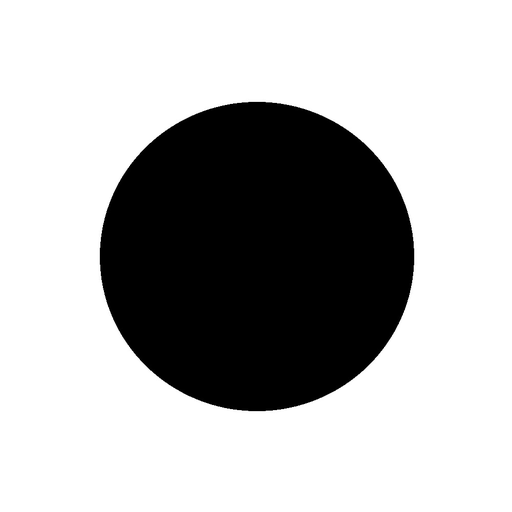

new shape torch.Size([1, 512, 512])


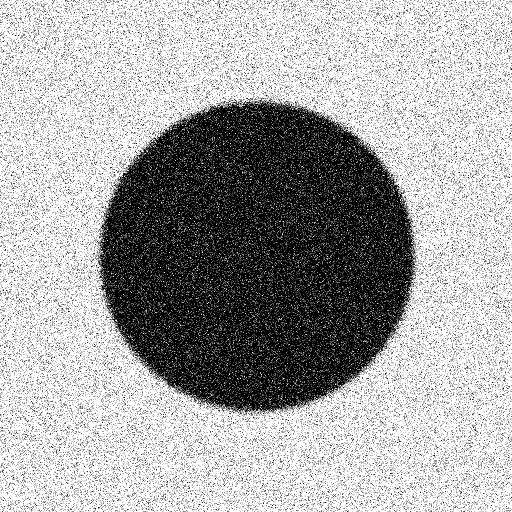

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]C:\Users\cleme\anaconda3\Lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:33<00:00, 295.40it/s]


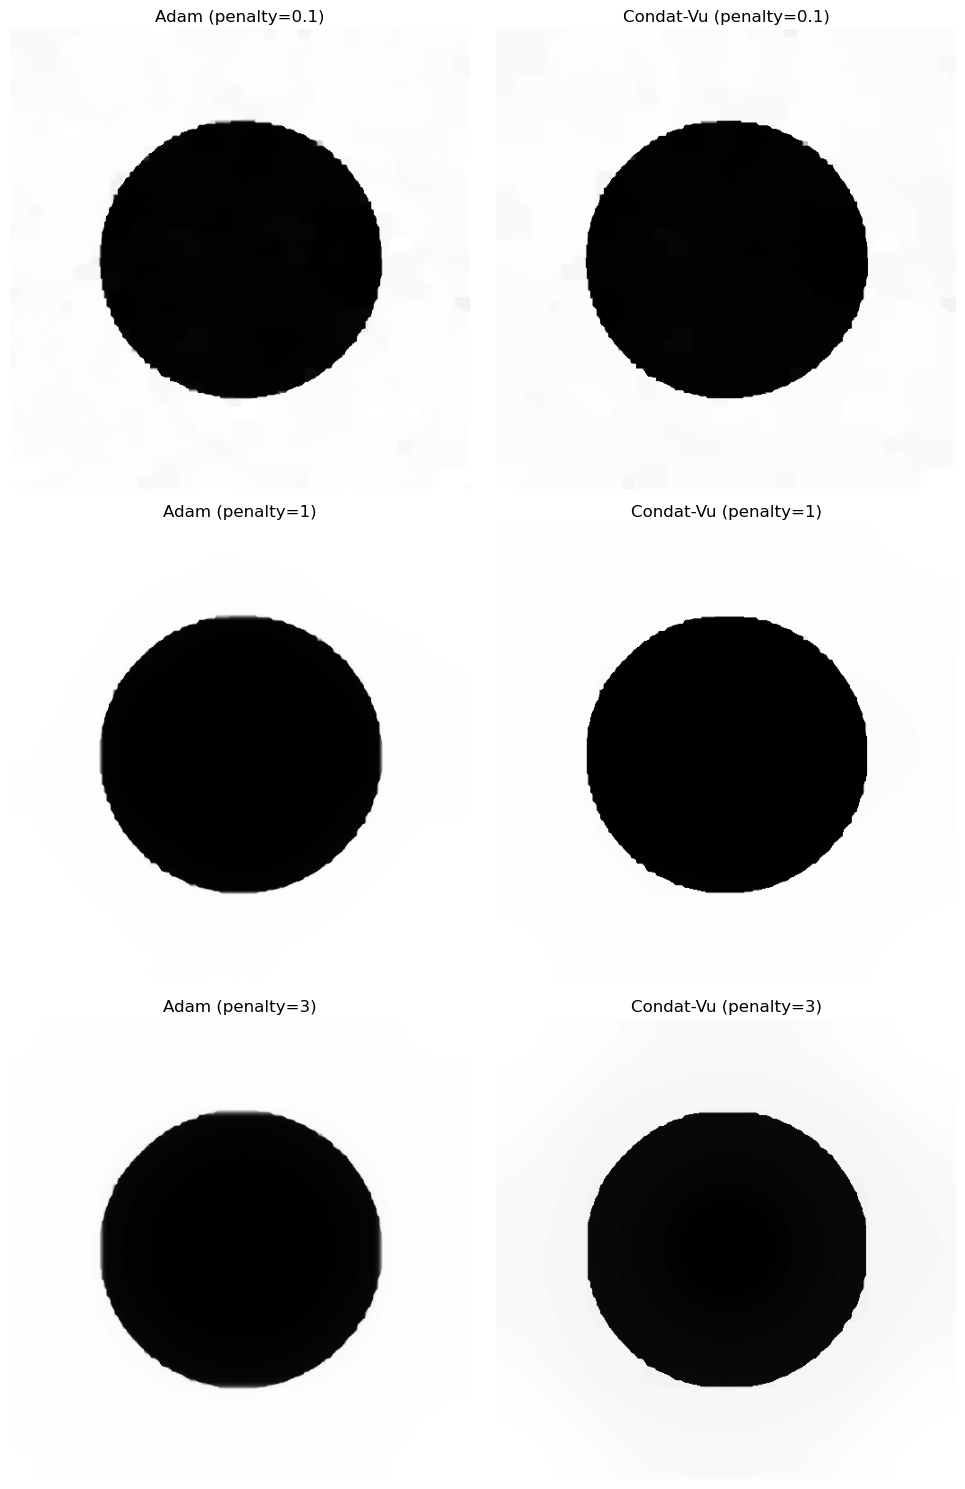

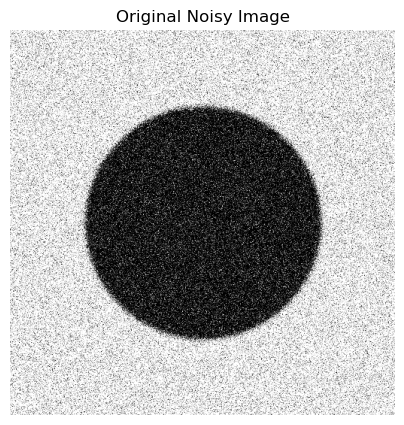

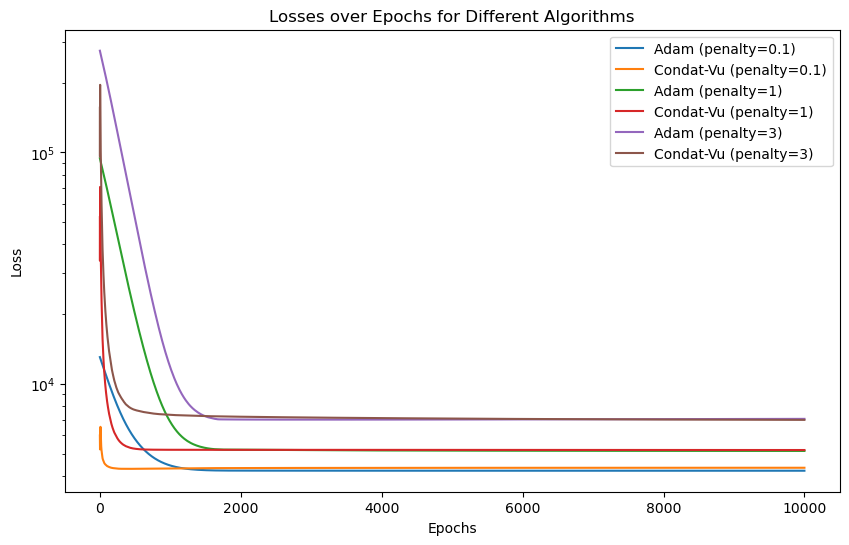

L^1 distance between denoized images and original image:
Adam (penalty=0.1) : 32221.068
Condat-Vu (penalty=0.1) : 31752.213
Adam (penalty=1) : 38499.906
Condat-Vu (penalty=1) : 34033.734
Adam (penalty=3) : 46017.375
Condat-Vu (penalty=3) : 39238.816


In [14]:
kernel_size = 13
gaussian_std = 3
std_noise = 0.3
penalty_weight = [0.1, 1, 3]

disc_image = crop_and_downsample("rond noir fond blanc.jpg")
disc_tensor = image_to_tensor(disc_image)
noisy_image = gaussian_blur_and_noise(disc_tensor, std_noise=std_noise, gaussian_std=gaussian_std, kernel_size=kernel_size, print_image=True)

list_names, list_losses, list_times, list_images,list_diff = accuracy_and_speed(["Adam", "Condat-Vu"],
                                                                      epochs=10000,noisy_image=noisy_image, original_image=disc_image, list_penalty_weights=penalty_weight,
                                                                      gaussian_std=gaussian_std, kernel_size=kernel_size, std_noise=std_noise)
from torchvision.transforms import ToPILImage
# Convert the PyTorch tensor to a PIL image
to_pil = ToPILImage()
noisy_image_pil = to_pil(noisy_image.squeeze())  # Squeeze is used to remove channel dimension if it's 1

# Now display the original noisy image
plt.figure(figsize=(5, 5))
plt.imshow(noisy_image_pil, cmap='gray')
plt.title("Original Noisy Image")
plt.axis('off')
plt.show()

# And separately plot the comparison of losses
plt.figure(figsize=(10, 6))
for losses, name in zip(list_losses, list_names):
    plt.plot(losses, label=name)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')  # Set the y-axis to logarithmic scale
plt.title('Losses over Epochs for Different Algorithms')
plt.legend()
plt.show()
print("L^1 distance between denoized images and original image:")
for diff, name in zip(list_diff, list_names):
  print(name, ":", diff.numpy())


### Dog image

original shape torch.Size([1, 600, 900])


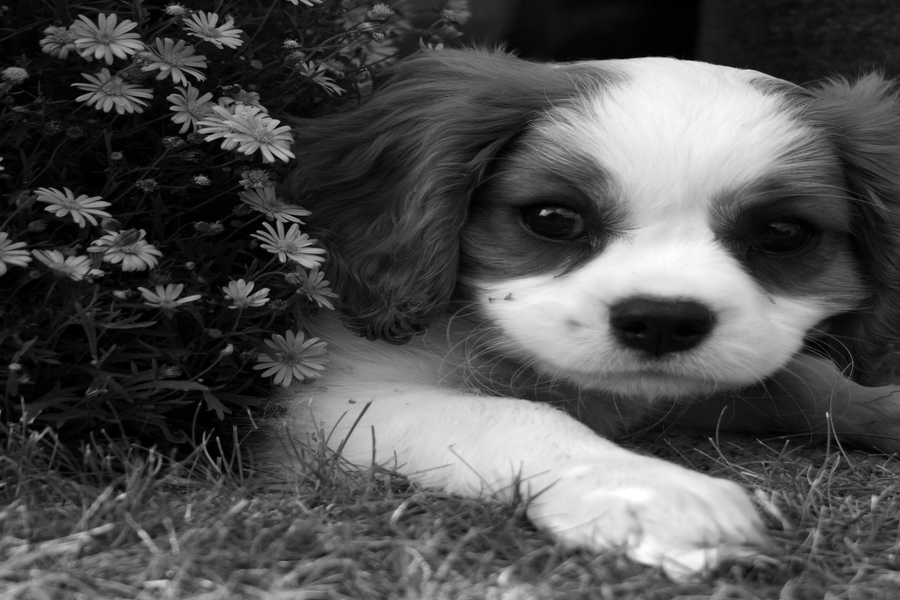

new shape torch.Size([1, 600, 900])


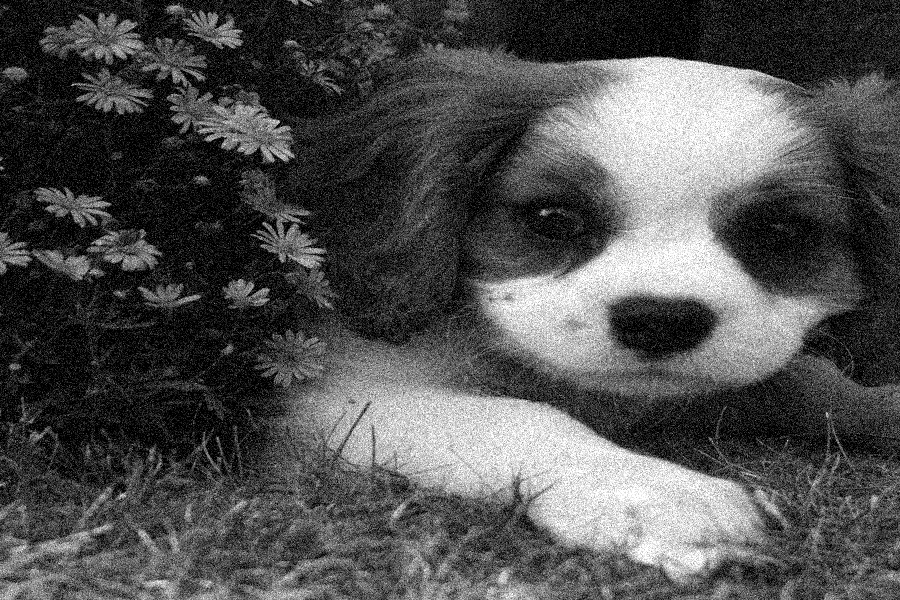

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:51<00:00, 192.83it/s]


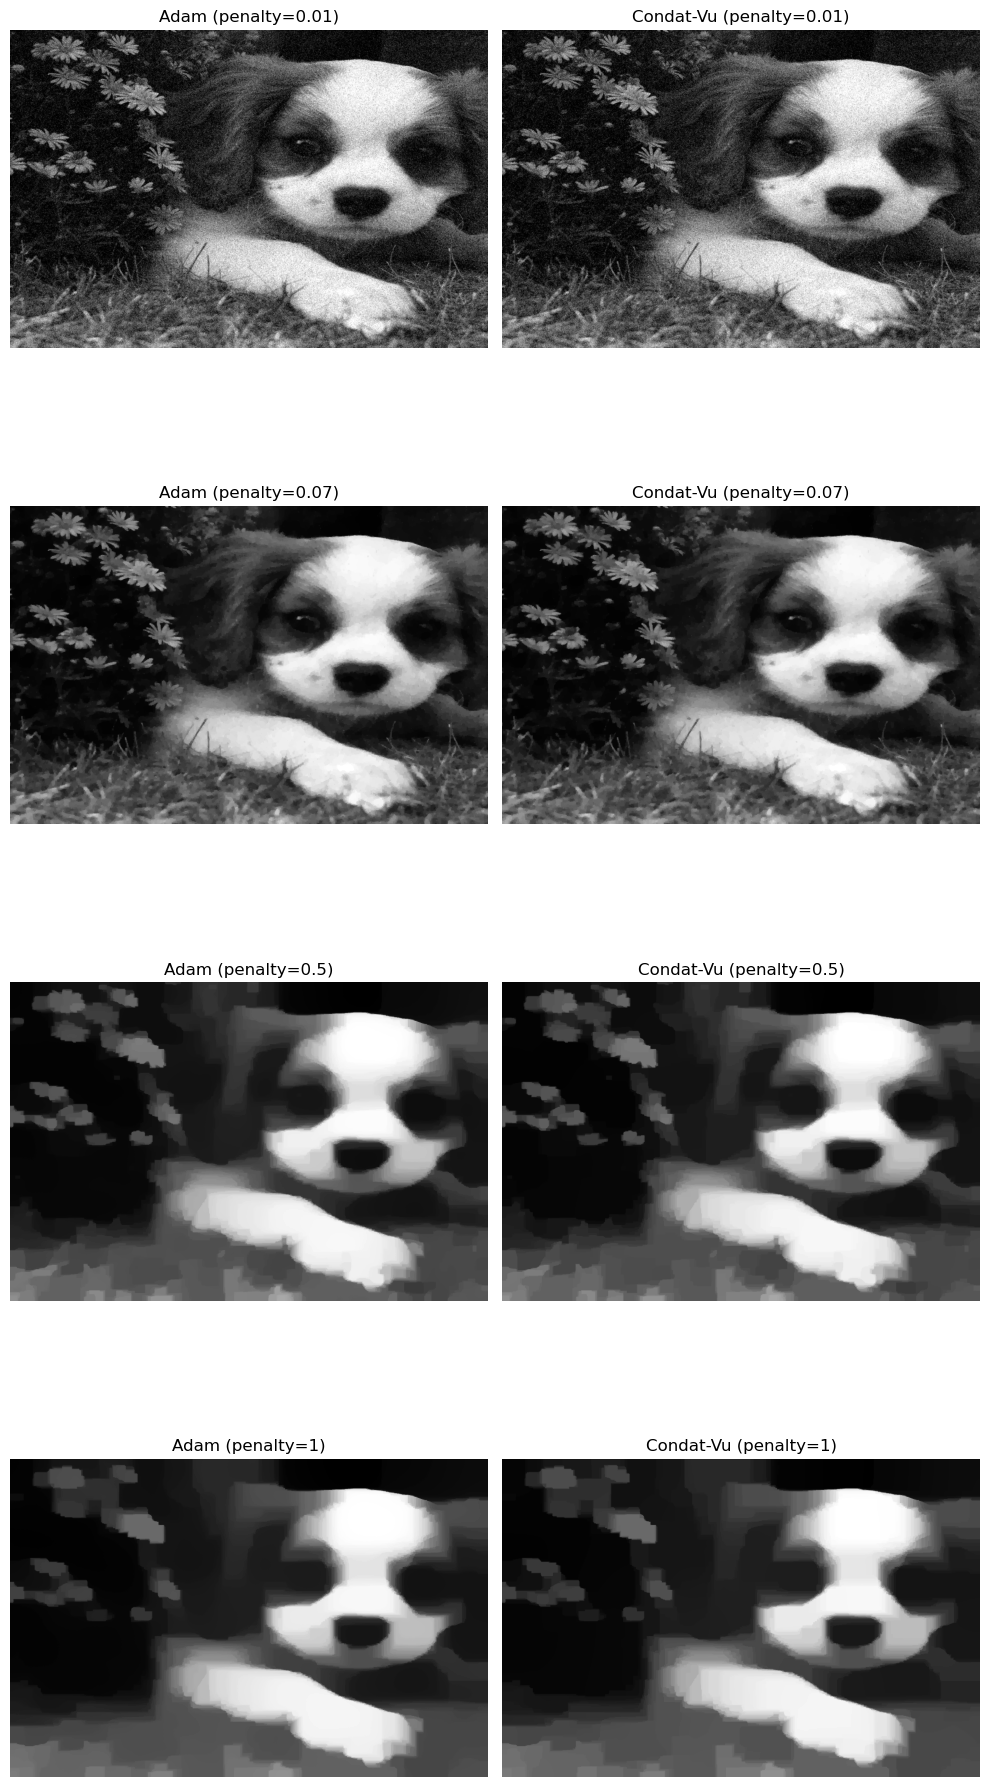

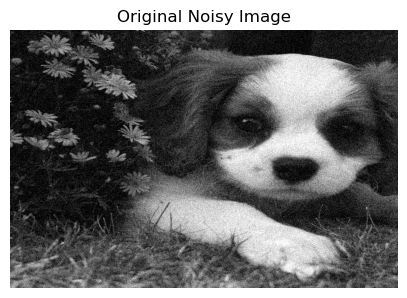

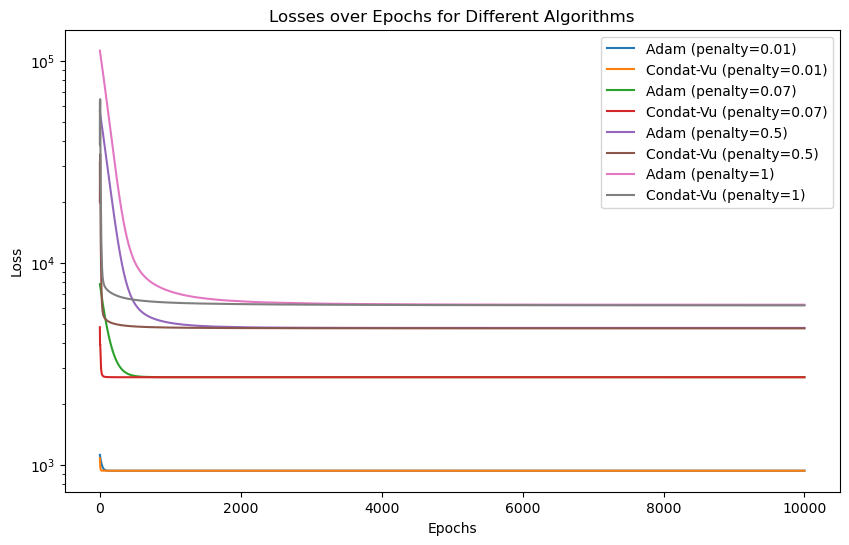

L^1 distance between denoized images and original image:
Adam (penalty=0.01) : 29889.219
Condat-Vu (penalty=0.01) : 29888.5
Adam (penalty=0.07) : 14507.697
Condat-Vu (penalty=0.07) : 14491.557
Adam (penalty=0.5) : 27016.723
Condat-Vu (penalty=0.5) : 26771.338
Adam (penalty=1) : 33732.992
Condat-Vu (penalty=1) : 33768.6


In [15]:
kernel_size = 9
gaussian_std = 0.2
std_noise = 0.1
penalty_weight = [0.01, 0.07,0.5,1]

dog_image=crop_and_downsample("dog.jpg",size=(900,600))
dog_tensor=image_to_tensor(dog_image)
dog_noisy_blurred= gaussian_blur_and_noise(dog_tensor,std_noise=std_noise,gaussian_std=gaussian_std,kernel_size=kernel_size,print_image=True,image_size=(900,600))

list_names, list_losses, list_times, list_images, list_diff = accuracy_and_speed(["Adam", "Condat-Vu"],
                                                                      epochs=10000,noisy_image=dog_noisy_blurred, original_image=dog_image, list_penalty_weights=penalty_weight, gaussian_std=gaussian_std,
                                                                      kernel_size=kernel_size, std_noise=std_noise)
from torchvision.transforms import ToPILImage
# Convert the PyTorch tensor to a PIL image
to_pil = ToPILImage()
noisy_dog_pil = to_pil(dog_noisy_blurred.squeeze())  # Squeeze is used to remove channel dimension if it's 1

# Now display the original noisy image
plt.figure(figsize=(5, 5))
plt.imshow(noisy_dog_pil, cmap='gray')
plt.title("Original Noisy Image")
plt.axis('off')
plt.show()

# And separately plot the comparison of losses
plt.figure(figsize=(10, 6))
for losses, name in zip(list_losses, list_names):
    plt.plot(losses, label=name)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')  # Set the y-axis to logarithmic scale
plt.title('Losses over Epochs for Different Algorithms')
plt.legend()
plt.show()
print("L^1 distance between denoized images and original image:")
for diff, name in zip(list_diff, list_names):
  print(name, ":", diff.numpy())



We find that the Condat-Vu algorithm with $\alpha=0.07$ gives a satisfying result:

original image


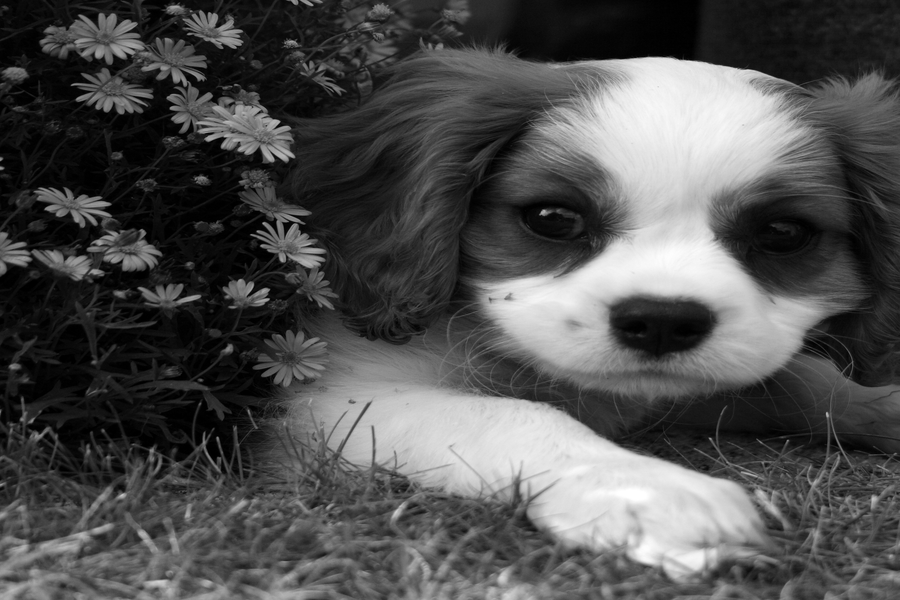

noised image


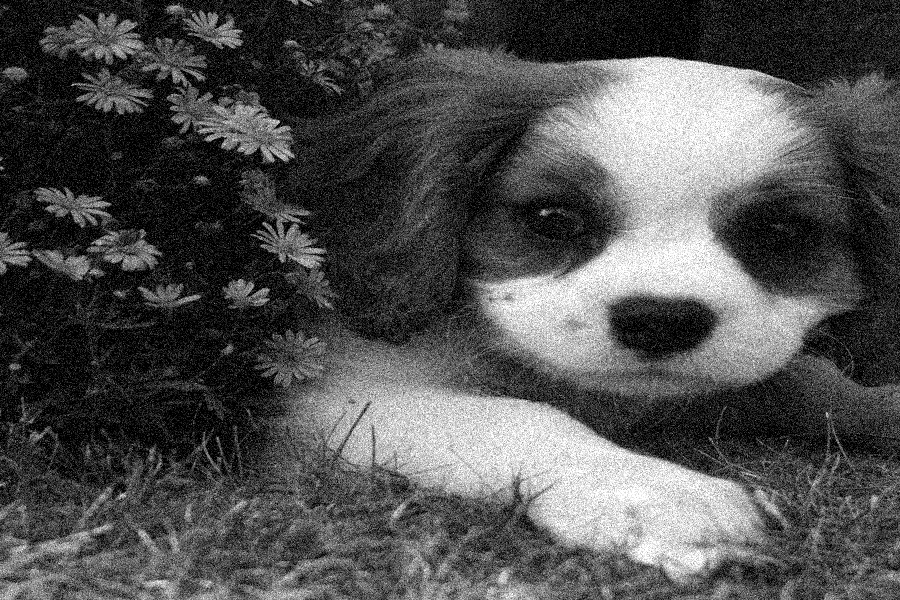

Condat-Vu (penalty=0.07)


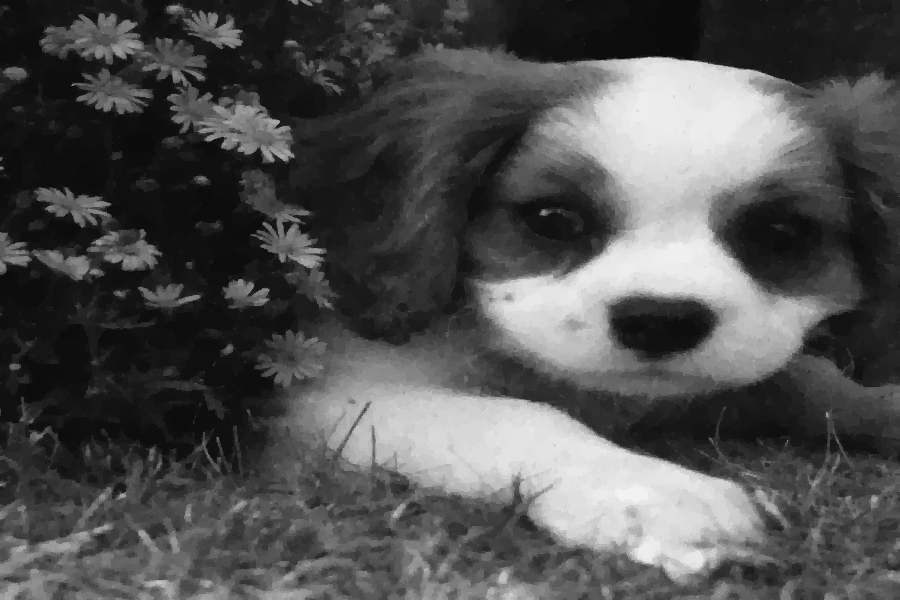

In [16]:
print('original image')
display(dog_image)
print('noised image')
display(noisy_dog_pil)
print(list_names[3])
display(list_images[3])

# Results
We find that Adam and Condat-Vu give the same minimum value for the loss. However, Condat-Vu has a faster convergence speed and also runs much faster on CPU, and twice as fast on a GPU.

The coefficient $\alpha$ in front of the total variation term in the loss function is an important parameter. Indeed, in the second example, we observe that the result the algorithms with $\alpha=1$ is clearly not satisfying.
This coefficient reflects the importance we give to the total variation term, which tends to smooth out the image.

Thus, if one desires to denoise an image which has a lot of details, as in the second example, one must take a small value for $\alpha$.